# Comparing NCBI and Prokka Genome Annotations

## Setup

### Import Required Packages

In [207]:
from collections import Counter
from glob import glob
import os
from pathlib import Path

import Bio
from Bio import Entrez, SeqIO
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Set Global Variables

In [2]:
DATA_PATH = Path('..', 'data')
GENOME_DIR = Path(DATA_PATH, 'e_coli_genomes')
PROKKA_DIR = Path(GENOME_DIR, 'prokka')
NCBI_DIR = Path(GENOME_DIR, 'ncbi')

### Helper Functions

In [15]:
def make_blast_db(db_id, db_type='nucl', overwrite=False):
    if os.path.isfile(db_id+'.nhr') and overwrite==False:
        print(db_id, db_type,' blast db exists, skipping')
        return
      
    """ make a blast db (BLAST 2.2.26+) """
    cmd_line = f'makeblastdb -in {db_id}.fasta -dbtype {db_type} -parse-seqids -out {db_id}'
    cmd_line='makeblastdb -in %s.fasta -dbtype %s -parse-seqids -out' % (db_id, db_type)
    print('making blast db with following command line...')
    print(cmd_line)
    os.system(cmd_line)

def run_blastp(
        seq, db, in_folder='prots', out_folder='bbh',
        out=None, outfmt=6, evalue=0.001, threads=1
    ):

    if out==None:
        seq_folder = seq.split('/')[0]
        db_folder = db.split('/')[0]
        seq_file = seq.split('/')[-1].split('.')[0]
        db_file = db.split('/')[-1].split('.')[0]
        out='%s_vs_%s.txt' % (seq_file, db_file)
        embed()

    files = glob('%s/*.txt' % out_folder)
    if out in files:
        print(seq, 'already blasted')
        return
   
    print('blasting %s vs %s' % (seq, db))

    cmd_line='blastp -db %s -query %s -out %s -evalue %s -outfmt %s -num_threads %i' \
    %(db, seq, out, evalue, outfmt, threads)
   
    print('running blastp with following command line...')
    print(cmd_line)
    os.system(cmd_line)
    return out
   
def run_blastn(seq, db, out=None, outfmt=6, evalue=0.001, threads=1):
   
    print('blasting %s vs %s' % (seq, db))
   
    db = '%s' % (db)
    seq = '%s' % (seq)
    cmd_line='blastn -db %s -query %s -out %s -evalue %s -outfmt %s -num_threads %i' \
    %(db, seq, out, evalue, outfmt, threads)

    print('running blastn with following command line...')
    print(cmd_line)
    os.system(cmd_line)
    return out

def parse_genome(in_file):
    """
    takes in a GBK file, ouputs a fasta file of either protein (type=prot) or nucleotide (type=nucl) sequences
    """
   
    # parse the GenBank record and save the sequences in FASTA format
    records = SeqIO.parse(in_file, "genbank")

    out_file = Path(in_file.parent, f'{strain_id}.fa')
    with open(out_file, 'w') as write_file:

        locus_backup_counter = 0
        for record in records:
            for feat in record.features:
                if feat.type=='CDS':

                    seq = str(feat.extract(record.seq))

                    if 'locus_tag' in feat.qualifiers.keys():
                        locus = feat.qualifiers['locus_tag'][0]
                    elif 'gene' in feat.qualifiers.keys():
                        locus = feat.qualifiers['gene'][0]
                    else:
                        raise ValueError(f'{feat.qualifiers} has neither locus tag nor gene key')
                    write_file.write(f'>{locus}\n{seq}\n')

## Create FASTA Files for Annotations

In [16]:
for prokka_file in os.listdir(PROKKA_DIR):
    strain_id, file_type = prokka_file.split('.')
    if file_type == 'gbk' and not os.path.isfile(Path(PROKKA_DIR, f'{strain_id}.fa')):
        parse_genome(Path(PROKKA_DIR, prokka_file))

In [17]:
for ncbi_file in os.listdir(NCBI_DIR):
    strain_id, file_type = ncbi_file.split('.')
    if file_type == 'gb' and not os.path.isfile(Path(NCBI_DIR, f'{strain_id}.fa')):
        parse_genome(Path(NCBI_DIR, ncbi_file))

## Run BLAST

Done from the command line

To make BLAST DB (in Prokka directory):

```shell
for fasta_file in *.fa
do
makeblastdb -in $fasta_file -out ${fasta_file%".fa"} -parse_seqids -dbtype nucl
done
```

To query NCBI against Prokka reference (from NCBI directory)

```shell
for ncbi_fasta in *.fa
do
blastn -db ../prokka/${ncbi_fasta%".fa"} -query $ncbi_fasta -out ${ncbi_fasta%".fa"}.csv -evalue 0.001 -outfmt 10 -num_threads 4
done
```

## Analyzing Differences

Here we want to pick out all of the different cases for matches/partials between the annotations:

- Perfect: the gene has the exact same sequence in each annotation
- Truncated: one of the genes is a complete matching subset of the other
- Variant: the overlap is perfect length-wise, but the sequence alignment isn't 100%
- Partial: a subset of each gene overlaps, either with full sequence match or not
- Unique: the gene gave no hits in the other annotation

In [144]:
column_names = [
    'ncbi_id', 'prokka_id', 'percent', 'align_length', 'n_mismatch', 'n_gapopen',
    'ncbi_start', 'ncbi_end', 'prokka_start', 'prokka_end', 'e_value', 'bit_score'
]

blast_results = {}
for ncbi_file in os.listdir(NCBI_DIR):
    strain_id, file_type = ncbi_file.split('.')
    if file_type == 'csv':
        blast_report_df = pd.read_csv(Path(NCBI_DIR, ncbi_file), header=0, names=column_names)
        blast_results[strain_id] = blast_report_df

for strain_id, blast_result_df in blast_results.items():
    
    # get each of the genbank records
    prokka_record = SeqIO.read(Path(PROKKA_DIR, f'{strain_id}.gbk'), 'gb')
    prokka_cdses = [f for f in prokka_record.features if f.type == 'CDS']
    prokka_id_to_feat = {}
    for prokka_cds in prokka_cdses:
        if 'locus_tag' in prokka_cds.qualifiers:
            prokka_feat_id = prokka_cds.qualifiers['locus_tag'][0]
        else:
            prokka_feat_id = prokka_cds.qualifiers['gene'][0]
        prokka_id_to_feat[prokka_feat_id] = prokka_cds
    
    ncbi_record = SeqIO.read(Path(NCBI_DIR, f'{strain_id}.gb'), 'gb')
    ncbi_cdses = [f for f in ncbi_record.features if f.type == 'CDS']
    ncbi_id_to_feat = {}
    for ncbi_cds in ncbi_cdses:
        if 'locus_tag' in ncbi_cds.qualifiers:
            ncbi_feat_id = ncbi_cds.qualifiers['locus_tag'][0]
        else:
            ncbi_feat_id = ncbi_cds.qualifiers['gene'][0]
        ncbi_id_to_feat[ncbi_feat_id] = ncbi_cds
        
    # for each hit in the BLAST result df, figure out what kind of match it is
    match_types = []
    for result_row in blast_result_df.itertuples(index=False):

        prokka_feat, ncbi_feat = prokka_id_to_feat[result_row.prokka_id], ncbi_id_to_feat[result_row.ncbi_id]
        # there's a weird case with dnaX (ribosomal slippage); let's just ignore compound locations for now
        if isinstance(ncbi_feat.location, Bio.SeqFeature.CompoundLocation):
            match_types.append('perfect')
            continue
        prokka_len, ncbi_len = len(prokka_feat.location), len(ncbi_feat.location)
        align_len = result_row.align_length
        
        # check for the length match; could be a perfect match (if alignment is 100), or a "variant"
        if align_len == prokka_len == ncbi_len:
            if result_row.n_mismatch == 0:
                match_types.append('perfect')
            else:
                match_types.append('variant')
        # if the align length matches either one of the feature lengths , we have a truncated case
        elif result_row.percent == 100 and (align_len == prokka_len or align_len == ncbi_len):
            match_types.append('truncated')
        # otherwise, we have a partial match, because the match region doesn't hit the full length of either gene
        else:
            match_types.append('partial')
    
    blast_result_df['match_type'] = match_types
    
    # we want to just keep one entry for each perfect/truncated/variant match
    for match_type in ['perfect', 'variant', 'truncated']:
        prokka_match_ids = blast_result_df[blast_result_df['match_type'] == match_type]['prokka_id']
        ncbi_match_ids = blast_result_df[blast_result_df['match_type'] == match_type]['ncbi_id']
        drop_idx = blast_result_df[
            (
                (blast_result_df['prokka_id'].isin(prokka_match_ids)) &
                (blast_result_df['match_type'] != match_type)
            ) | (
                (blast_result_df['ncbi_id'].isin(ncbi_match_ids)) &
                (blast_result_df['match_type'] != match_type)
            )
        ].index
        blast_result_df = blast_result_df.drop(index=drop_idx)
    
    # unique genes are still not handled, because by definition they don't show up in the result dataframe
    # so let's figure out which gene IDs from each annotation are in that category and add them as dummy rows
    prokka_unique = set(prokka_id_to_feat.keys()) - set(blast_result_df['prokka_id'])
    prokka_unique_append_df = pd.DataFrame(columns=blast_result_df.columns)
    prokka_unique_append_df['prokka_id'] = list(prokka_unique)
    prokka_unique_append_df['match_type'] = 'unique'
    blast_result_df = pd.concat([blast_result_df, prokka_unique_append_df])
    
    ncbi_unique = set(ncbi_id_to_feat.keys()) - set(blast_result_df['ncbi_id'])
    ncbi_unique_append_df = pd.DataFrame(columns=blast_result_df.columns)
    ncbi_unique_append_df['ncbi_id'] = list(ncbi_unique)
    ncbi_unique_append_df['match_type'] = 'unique'
    blast_result_df = pd.concat([blast_result_df, ncbi_unique_append_df])
    
    blast_results[strain_id] = blast_result_df

Now let's parse through these results and see how each strain breaks down:

In [4]:
genome_info_df = pd.read_excel(Path(GENOME_DIR, 'lab_strains.xlsx'))
genome_info_df = genome_info_df.set_index('id')

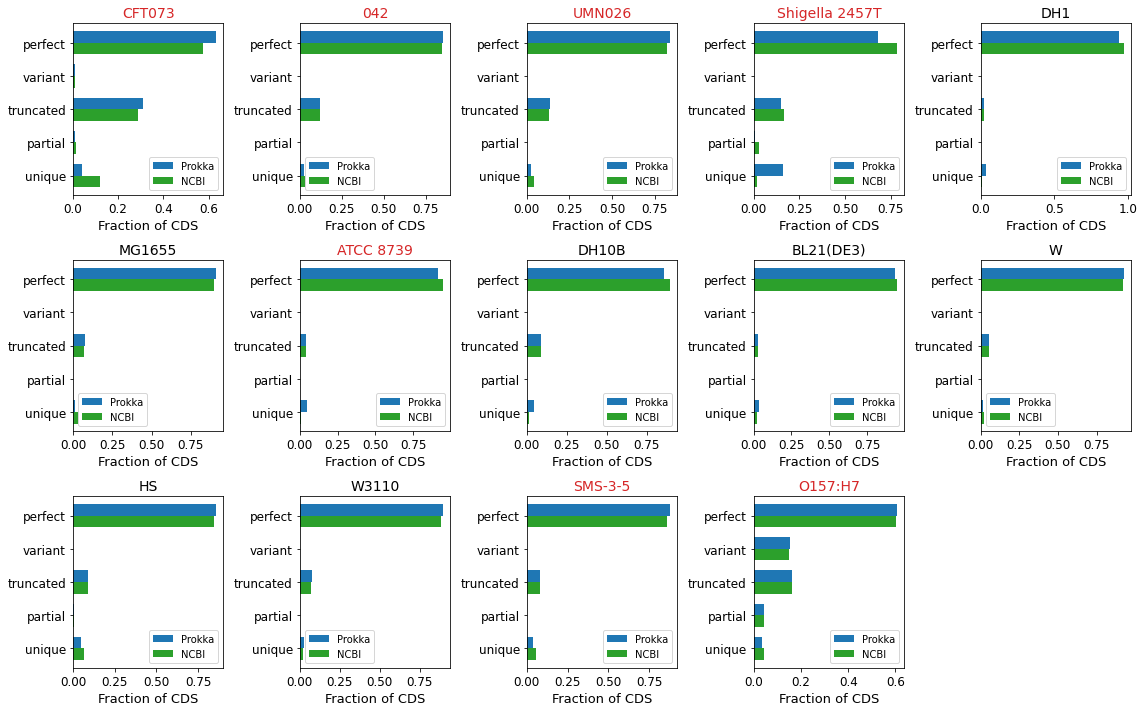

In [145]:
_, axs = plt.subplots(3, 5, figsize=(16, 10))
axs = axs.flatten()

for ax, (strain_id, blast_result_df) in zip(axs, blast_results.items()):

    # get each of the genbank records
    prokka_record = SeqIO.read(Path(PROKKA_DIR, f'{strain_id}.gbk'), 'gb')
    prokka_cdses = [f for f in prokka_record.features if f.type == 'CDS']
    n_prokka_cds = len(prokka_cdses)
    
    ncbi_record = SeqIO.read(Path(NCBI_DIR, f'{strain_id}.gb'), 'gb')
    ncbi_cdses = [f for f in ncbi_record.features if f.type == 'CDS']
    n_ncbi_cds = len(ncbi_cdses)
    
    # these should each be unique instances
    match_types = ['perfect', 'variant', 'truncated', 'partial', 'unique']
    match_counts_prokka = []
    match_counts_ncbi = []
    for match_type in match_types:
        match_type_df = blast_result_df[blast_result_df['match_type'] == match_type]
        match_counts_prokka.append(len(match_type_df['prokka_id'].dropna().unique()))
        match_counts_ncbi.append(len(match_type_df['ncbi_id'].dropna().unique()))
        
    match_fracs_prokka = np.array(match_counts_prokka) / n_prokka_cds
    match_fracs_ncbi = np.array(match_counts_ncbi) / n_ncbi_cds
    
    y_range = np.flip(np.arange(len(match_types)))
    ax.barh(y_range, match_fracs_prokka, label='Prokka', color='tab:blue', align='edge', height=0.35)
    ax.barh(y_range, match_fracs_ncbi, label='NCBI', color='tab:green', align='edge', height=-0.35)
    ax.legend()
    
    ax.set_yticks(y_range)
    ax.set_yticklabels(match_types)
    
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel('Fraction of CDS', fontsize=13)
    short_name = genome_info_df.loc[strain_id, 'short_name']
    pathogenic = not genome_info_df.loc[strain_id, 'pathotype'] == 'Commensal'
    if pathogenic:
        title_color = 'tab:red'
    else:
        title_color = 'k'
    ax.set_title(short_name, fontsize=14, color=title_color)

axs[-1].set_visible(False)
plt.tight_layout()

### Truncated Comparison

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0.5, 0, '# of Longer in Truncation Pair')

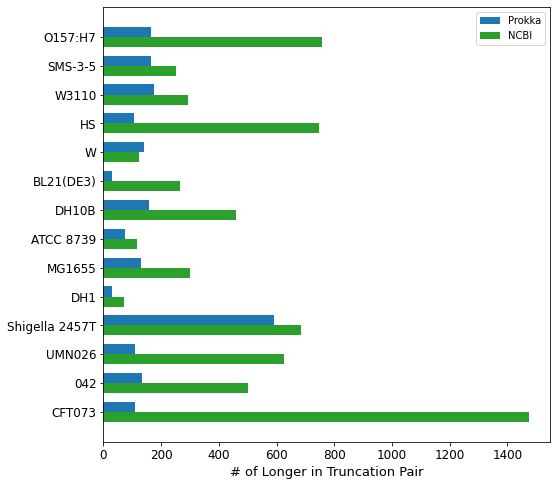

In [146]:
prokka_longer = []
ncbi_longer = []
short_names = []
for strain_id, blast_result_df in blast_results.items():

    truncated_df = blast_result_df[blast_result_df['match_type'] == 'truncated']
    truncated_df['ncbi_longer'] = truncated_df['ncbi_start'] > truncated_df['prokka_start']
    
    n_ncbi_longer = truncated_df['ncbi_longer'].sum()
    prokka_longer.append(truncated_df.shape[0] - n_ncbi_longer)
    ncbi_longer.append(n_ncbi_longer)
    
    short_names.append(genome_info_df.loc[strain_id, 'short_name'])

_, ax = plt.subplots(figsize=(8, 8))  

y_range = np.arange(len(ncbi_longer))
ax.barh(y_range, prokka_longer, label='Prokka', color='tab:blue', align='edge', height=0.35)
ax.barh(y_range, ncbi_longer, label='NCBI', color='tab:green', align='edge', height=-0.35)
ax.legend()

ax.set_yticks(y_range)
ax.set_yticklabels(short_names)

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('# of Longer in Truncation Pair', fontsize=13)

### Deeper Dive into Truncated Pairs

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


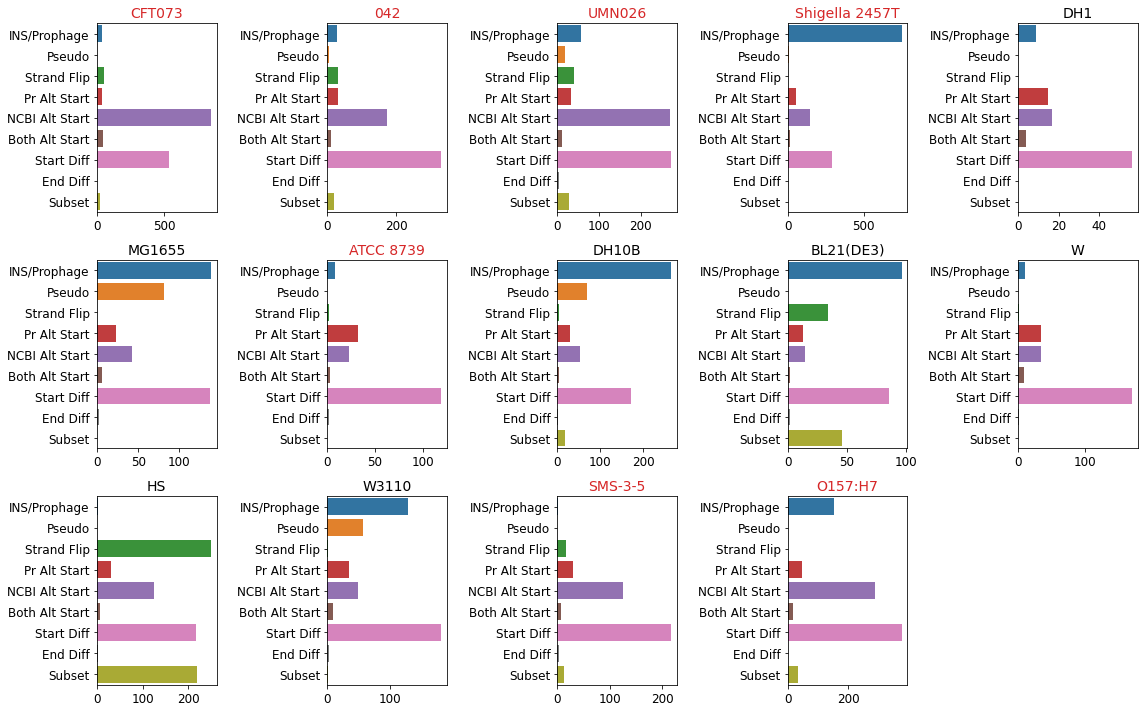

In [261]:
_, axs = plt.subplots(3, 5, figsize=(16, 10))
axs = axs.flatten()

for (strain_id, blast_result_df), ax in zip(blast_results.items(), axs):
    # get each of the genbank records
    prokka_record = SeqIO.read(Path(PROKKA_DIR, f'{strain_id}.gbk'), 'gb')
    prokka_cdses = [f for f in prokka_record.features if f.type == 'CDS']
    prokka_id_to_feat = {}
    for prokka_cds in prokka_cdses:
        if 'locus_tag' in prokka_cds.qualifiers:
            prokka_feat_id = prokka_cds.qualifiers['locus_tag'][0]
        else:
            prokka_feat_id = prokka_cds.qualifiers['gene'][0]
        prokka_id_to_feat[prokka_feat_id] = prokka_cds

    ncbi_record = SeqIO.read(Path(NCBI_DIR, f'{strain_id}.gb'), 'gb')
    ncbi_cdses = [f for f in ncbi_record.features if f.type == 'CDS']
    ncbi_id_to_feat = {}
    for ncbi_cds in ncbi_cdses:
        if 'locus_tag' in ncbi_cds.qualifiers:
            ncbi_feat_id = ncbi_cds.qualifiers['locus_tag'][0]
        else:
            ncbi_feat_id = ncbi_cds.qualifiers['gene'][0]
        ncbi_id_to_feat[ncbi_feat_id] = ncbi_cds

    truncated_df = blast_result_df[blast_result_df['match_type'] == 'truncated']

    # determine if any of the genes are pseudogenes
    def categorize_match(row):

        prokka_id = row['prokka_id']
        ncbi_id = row['ncbi_id']

        prokka_feat = prokka_id_to_feat[prokka_id]
        ncbi_feat = ncbi_id_to_feat[ncbi_id]

        if 'pseudo' in ncbi_feat.qualifiers:
            category = 'Pseudo'
        elif (
                'ins' in ncbi_feat.qualifiers['product'][0].lower() or 
                'ins' in ncbi_feat.qualifiers.get('gene', [''])[0].lower() or 
                'ins' in ncbi_feat.qualifiers.get('note', [''])[0].lower() or 
                'transposon' in ncbi_feat.qualifiers.get('note', [''])[0].lower() or 
                'prophage' in ncbi_feat.qualifiers['product'][0].lower()
            ):
            category = 'INS/Prophage'
        else:
            prokka_location = prokka_feat.location
            ncbi_location = ncbi_feat.location
            if prokka_location.strand != ncbi_location.strand:
                category = 'Strand Flip'
            elif (
                    (
                        ncbi_location.strand == prokka_location.strand == 1 and
                        ncbi_location.start.position != prokka_location.start.position and
                        ncbi_location.end.position == prokka_location.end.position
                    ) or 
                    (
                        ncbi_location.strand == prokka_location.strand == -1 and
                        ncbi_location.start.position == prokka_location.start.position and
                        ncbi_location.end.position != prokka_location.end.position
                    )
                ):
                prokka_start_codon = str(prokka_location.extract(prokka_record.seq)[:3])
                ncbi_start_codon = str(ncbi_location.extract(ncbi_record.seq)[:3])
                if ncbi_start_codon != prokka_start_codon:
                    if ncbi_start_codon == 'ATG' and prokka_start_codon != 'ATG':
                        category = 'Pr Alt Start'
                    elif ncbi_start_codon != 'ATG' and prokka_start_codon == 'ATG':
                        category = 'NCBI Alt Start'
                    else:
                        category = 'Both Alt Start'
                else:
                    category = 'Start Diff'
            elif (
                    (
                        ncbi_location.strand == prokka_location.strand == 1 and
                        ncbi_location.start.position == prokka_location.start.position and
                        ncbi_location.end.position != prokka_location.end.position
                    ) or 
                    (
                        ncbi_location.strand == prokka_location.strand == -1 and
                        ncbi_location.start.position != prokka_location.start.position and
                        ncbi_location.end.position == prokka_location.end.position
                    )
                ):
                category = 'End Diff'

            elif (
                    (prokka_location.start.position != ncbi_location.start.position) and 
                    (prokka_location.end.position != ncbi_location.end.position)
                ):
                category = 'Subset'
            else:
                print(row)

        return category

    truncated_df['category'] = truncated_df.apply(categorize_match, axis=1)
        
    sns.countplot(
        y="category",
        data=truncated_df,
        order=[
            'INS/Prophage', 'Pseudo', 'Strand Flip', 'Pr Alt Start',
            'NCBI Alt Start', 'Both Alt Start',
            'Start Diff', 'End Diff', 'Subset'
        ],
        ax=ax
    )
    short_name = genome_info_df.loc[strain_id, 'short_name']
    pathogenic = not genome_info_df.loc[strain_id, 'pathotype'] == 'Commensal'
    if pathogenic:
        title_color = 'tab:red'
    else:
        title_color = 'k'
    ax.set_title(short_name, fontsize=14, color=title_color)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=12)
    
    
axs[-1].set_visible(False)    
plt.tight_layout()

In [263]:
truncated_df[truncated_df['category'] == 'Start Diff']

,ncbi_id,prokka_id,percent,align_length,n_mismatch,n_gapopen,ncbi_start,ncbi_end,prokka_start,prokka_end,e_value,bit_score,match_type,category
15,Z0019,AE005174_00016,100.0,900,0,0,7,906,1,900,0.000000e+00,1663.0,truncated,Start Diff
16,Z0020,AE005174_00017,100.0,426,0,0,199,624,1,426,0.000000e+00,787.0,truncated,Start Diff
35,Z0041,AE005174_00035,100.0,591,0,0,22,612,1,591,0.000000e+00,1092.0,truncated,Start Diff
36,Z0042,AE005174_00036,100.0,786,0,0,109,894,1,786,0.000000e+00,1452.0,truncated,Start Diff
37,Z0043,AE005174_00037,100.0,1554,0,0,16,1569,1,1554,0.000000e+00,2870.0,truncated,Start Diff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174,Z5976,AE005174_05403,100.0,1590,0,0,1,1590,28,1617,0.000000e+00,2937.0,truncated,Start Diff
9176,Z5978,AE005174_05405,100.0,162,0,0,19,180,1,162,3.030000e-82,300.0,truncated,Start Diff
9191,Z5991,AE005174_05418,100.0,1233,0,0,22,1254,1,1233,0.000000e+00,2278.0,truncated,Start Diff
9194,Z5995,AE005174_05422,100.0,297,0,0,31,327,1,297,5.250000e-157,549.0,truncated,Start Diff


In [265]:
ncbi_test = ncbi_id_to_feat['Z0043']
print(ncbi_test)

type: CDS
location: [40677:42246](-)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: function, Value: ["putative enzyme; Central intermediary metabolism: Pool, multipurpose conversions of intermed. met'm"]
    Key: gene, Value: ['caiC']
    Key: locus_tag, Value: ['Z0043']
    Key: note, Value: ['Residues 1 to 522 of 522 are 97.89 pct identical to residues 1 to 522 of 522 from Escherichia coli K-12 Strain MG1655: B0037']
    Key: product, Value: ['probable crotonobetaine/carnitine-CoA ligase']
    Key: protein_id, Value: ['AAG54340.1']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MDRGAMDIIGGQHLRQMWDDLADVYGHKTALICESSGGVVNRYSYLELNQEINRTANLFYTLGIRKGDKVALHLDNCPEFIFCWFGLAKIGAIMVPINARLLREESAWILQNSQACLLVTSAQFYPMYQQIQQEDATQLRHICLTDVALPADDGVSSFTQLKNQQPATLCYAPPLSTDDTAEILFTSGTTSRPKGVVITHYNLRFAGYYSAWQCALRDDDVYLTVMPAFHIDCQCTAAMAAFSAGATFVLVEKYSARAFWGQVQKYRATITECIPMMIRTLMVQPPSANDRQHRLREVMFYLNLSEQEKDTFCERFGVRLLTSYGMTETIVGIIGDRPGDKRRWPSIGRAGFCYDAEIRDDHNRPLPAGEIGEICIKGVPGK

In [266]:
prokka_test = prokka_id_to_feat['AE005174_00037']
print(prokka_test)

type: CDS
location: [40677:42231](-)
qualifiers:
    Key: EC_number, Value: ['6.2.1.-']
    Key: codon_start, Value: ['1']
    Key: gene, Value: ['caiC']
    Key: inference, Value: ['ab initio prediction:Prodigal:2.6', 'similar to AA sequence:UniProtKB:P31552']
    Key: locus_tag, Value: ['AE005174_00037']
    Key: product, Value: ['putative crotonobetaine/carnitine-CoA ligase']
    Key: protein_id, Value: ['SBRG:AE005174_00037']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MDIIGGQHLRQMWDDLADVYGHKTALICESSGGVVNRYSYLELNQEINRTANLFYTLGIRKGDKVALHLDNCPEFIFCWFGLAKIGAIMVPINARLLREESAWILQNSQACLLVTSAQFYPMYQQIQQEDATQLRHICLTDVALPADDGVSSFTQLKNQQPATLCYAPPLSTDDTAEILFTSGTTSRPKGVVITHYNLRFAGYYSAWQCALRDDDVYLTVMPAFHIDCQCTAAMAAFSAGATFVLVEKYSARAFWGQVQKYRATITECIPMMIRTLMVQPPSANDRQHRLREVMFYLNLSEQEKDTFCERFGVRLLTSYGMTETIVGIIGDRPGDKRRWPSIGRAGFCYDAEIRDDHNRPLPAGEIGEICIKGVPGKTIFKEYFLNPKATAKVLEADGWLHTGDTGYRDEEGFFYFIDRRCNMIKRGGENVSCVELENIIATHPKIQDIVVVGIKDSIRDEAIKAFVVLNEGETLSEEEFFRFCEQNMAKFKVPSYLE